In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import h5py
import os
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers import InputLayer, Input, Reshape, MaxPool2D, Conv2D, Dense, Flatten
from keras.models import Sequential, Model, load_model

Using TensorFlow backend.


### read mnist dataset

In [2]:
dataset_path = os.path.join("..", "assignment_4")
dataset_path = os.path.join(dataset_path, "dataset")
dataset_path = os.path.join(dataset_path, "mnist.npz")

dataset = np.load(dataset_path)
x_train = dataset["x_train"][:,:,:,np.newaxis] / 255
y_train = np_utils.to_categorical(dataset["y_train"])
x_test = dataset["x_test"][:,:,:,np.newaxis] / 255
y_test = np_utils.to_categorical( dataset["y_test"])

### print dataset shape

In [3]:
print("x_train.shape", x_train.shape)
print("y_train.shape", y_train.shape)
print("x_test.shape", x_test.shape)
print("y_test.shape", y_test.shape)

x_train.shape (60000, 28, 28, 1)
y_train.shape (60000, 10)
x_test.shape (10000, 28, 28, 1)
y_test.shape (10000, 10)


In [4]:
img_size = x_train.shape[1]
img_size_flat = x_train.shape[1] * x_train.shape[2]
img_shape = x_train[0].shape
img_shape_full = list(x_train[0].reshape((x_train.shape[1], x_train.shape[2], 1)).shape)
num_classes = 10
num_channels = 1

print("img_size : ", img_size)
print("img_size_flat : ", img_size_flat)
print("img_shape : ", img_shape)
print("img_shape_full : ", img_shape_full)
print("num_classes : ", num_classes)
print("num_channels : ", num_channels)

img_size :  28
img_size_flat :  784
img_shape :  (28, 28, 1)
img_shape_full :  [28, 28, 1]
num_classes :  10
num_channels :  1


### define plot function

In [5]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.figure(figsize=(12,12))
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze())
            
        ax.set_xlabel("True : {}".format(cls_true[i]) if cls_pred is None else
                     "True : {}, Pred : {}".format(cls_true[i], cls_pred[i]))
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()
    
def plot_example_errors(x_test, y_test, cls_pred, error_list):
    
    images = x_test[error_list]
    cls_pred = cls_pred[error_list]
    cls_true = y_test[error_list]
    
    plot_images(images[0:9], cls_true[0:9], cls_pred[0:9])
    
def plot_conv_weights(weights, input_channel=0):
    pass

### build neural network

In [6]:
model = Sequential([
    Conv2D(filters=16, kernel_size=5, padding='same', activation='relu',
          input_shape=img_shape_full),
    Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 817,482
Trainable params: 817,482
Non-trainable params: 0
________________________________________________

### test model

In [7]:
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

In [8]:
model.fit(x_train, y_train,
         batch_size=128,
         epochs=1,
         verbose=1,
         validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 74s 1ms/step - loss: 0.1725 - accuracy: 0.9490 - val_loss: 0.0479 - val_accuracy: 0.9835


In [9]:
result = model.evaluate(x_test, y_test, verbose=0)
print("test loss : {} | test accuracy: {}".format(result[0], result[1]))

test loss : 0.047858592895558105 | test accuracy: 0.9835000038146973


### predict

In [10]:
cls_pred = model.predict(x_test[:9],
                         batch_size=3,
                         verbose=1)

9/9 [==============================] - 0s 1ms/step


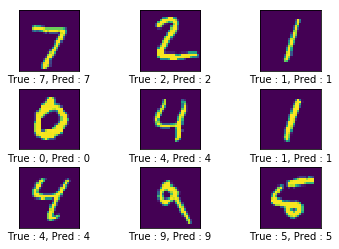

<Figure size 864x864 with 0 Axes>

In [11]:
plot_images(x_test[:9], 
            np.argmax(y_test[:9], axis=1), 
            np.argmax(cls_pred, axis=1))

### find error images

In [12]:
cls_pred = model.predict(x_test,
                         batch_size=3,
                         verbose=1)

cls_pred = np.argmax(cls_pred, axis=1)
y_test_tmp = np.argmax(y_test, axis=1)

10000/10000 [==============================] - 4s 407us/step


In [13]:
error_list = []
for i, pred in enumerate(cls_pred):
    if pred != y_test_tmp[i]:
        error_list.append(i)

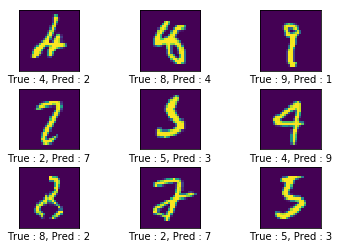

<Figure size 864x864 with 0 Axes>

In [14]:
plot_example_errors(x_test, y_test_tmp, cls_pred, error_list)

### rebuild neural network

In [15]:
inputs = Input(shape=(img_size_flat,))
net = inputs
net = Reshape(tuple(img_shape_full))(net)
net = Conv2D(filters=16, kernel_size=5, padding='same', activation='relu')(net)
net = MaxPool2D()(net)
net = Conv2D(filters=32, kernel_size=5, padding='same', activation='relu')(net)
net = MaxPool2D()(net)
net = Flatten()(net)
net = Dense(128, activation='relu')(net)
net = Dense(num_classes, activation='softmax')(net)
outputs = net

In [16]:
model2 = Model(inputs=inputs, outputs=outputs)

### retest model

In [17]:
model2.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [18]:
x_train_flat = x_train.reshape(x_train.shape[0],\
                          x_train.shape[1]*x_train.shape[2]).astype('float32')
x_test_flat = x_test.reshape(x_test.shape[0], \
                        x_test.shape[1]*x_test.shape[2]).astype('float32')

model2.fit(x_train_flat, y_train,
         batch_size=128,
         epochs=1,
         verbose=1,
         validation_data=(x_test_flat, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 28s 460us/step - loss: 0.1931 - accuracy: 0.9406 - val_loss: 0.0478 - val_accuracy: 0.9850


In [19]:
result = model2.evaluate(x_test_flat, y_test, verbose=0)
print("test loss : {} | test accuracy: {}".format(result[0], result[1]))

test loss : 0.047817975934245624 | test accuracy: 0.9850000143051147


### find error images

In [20]:
cls_pred = model2.predict(x_test_flat,
                         batch_size=3,
                         verbose=1)

cls_pred = np.argmax(cls_pred, axis=1)

10000/10000 [==============================] - 3s 323us/step


In [21]:
error_list = []
for i, pred in enumerate(cls_pred):
    if pred != y_test_tmp[i]:
        error_list.append(i)

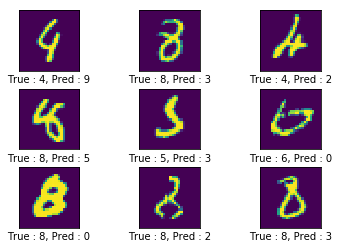

<Figure size 864x864 with 0 Axes>

In [22]:
plot_example_errors(x_test, y_test_tmp, cls_pred, error_list)

### save model

In [27]:
path_model = 'model/model2.h5'
model2.save(path_model)

del model2

### load model

In [29]:
model3 = load_model(path_model)

In [31]:
cls_pred = model3.predict(x_test_flat[:9],
                         batch_size=3,
                         verbose=1)

9/9 [==============================] - 0s 2ms/step


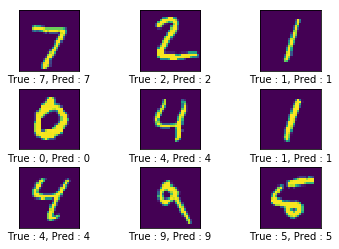

<Figure size 864x864 with 0 Axes>

In [32]:
plot_images(x_test[:9], 
            np.argmax(y_test[:9], axis=1), 
            np.argmax(cls_pred, axis=1))